# Module 21.6 

# Sentiment analysis with Naive Bayes

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prompt" data-toc-modified-id="Prompt-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Prompt</a></span></li><li><span><a href="#Approach" data-toc-modified-id="Approach-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Approach</a></span><ul class="toc-item"><li><span><a href="#Assumptions" data-toc-modified-id="Assumptions-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Assumptions</a></span></li></ul></li><li><span><a href="#Imports" data-toc-modified-id="Imports-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Setting-up-datasets" data-toc-modified-id="Setting-up-datasets-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Setting up datasets</a></span></li><li><span><a href="#Feature-engineering" data-toc-modified-id="Feature-engineering-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Feature engineering</a></span><ul class="toc-item"><li><span><a href="#Word-agnostic-features" data-toc-modified-id="Word-agnostic-features-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Word agnostic features</a></span></li></ul></li><li><span><a href="#Creating-model-v1" data-toc-modified-id="Creating-model-v1-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Creating model v1</a></span></li><li><span><a href="#Adding-new-features-to-the-dataset" data-toc-modified-id="Adding-new-features-to-the-dataset-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Adding new features to the dataset</a></span></li><li><span><a href="#Saving-the-amazon-model" data-toc-modified-id="Saving-the-amazon-model-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Saving the amazon model</a></span></li><li><span><a href="#Testing-the-Amazon-model-on-the-Yelp-and-IMDb-datasets" data-toc-modified-id="Testing-the-Amazon-model-on-the-Yelp-and-IMDb-datasets-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Testing the Amazon model on the Yelp and IMDb datasets</a></span></li></ul></div>

## Prompt

Implement a Naive-Bayes sentiment classifier using one of the companies from the [UCI Machine Learning](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences) database. Test how the model performs against the comments from the other websites.

## Approach

The model will incorporate for two types of features:
1. length of comment
2. types of words used in comment

(1) will be created by binning the word count of a particular comment against the word-counts for all comments in the database, and (2) will be created by counting whether or not a particular word is used in a comment.

### Assumptions
1. The first assumption is of the naivety of the NB algorithm: the features are unrelated. This is simply not true for any of the two kinds of features, but we will still make the assumption.

## Imports

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

import nltk #for tokenize sentences

In [44]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/chanvarma/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [2]:
datasets_file = "datasets/sentiment labelled sentences/"
imdb_t = datasets_file + 'imdb_labelled.txt'
amazon_t = datasets_file + 'amazon_cells_labelled.txt'
yelp_t = datasets_file + 'yelp_labelled.txt'

## Setting up datasets

In [482]:
imdb = pd.read_csv(imdb_t, sep = '\t', header = None)
imdb.columns = ['comment', 'positive']

amazon = pd.read_csv(amazon_t, sep = '\t', header = None)
amazon.columns = ['comment', 'positive']

yelp = pd.read_csv(yelp_t, sep = '\t', header = None)
yelp.columns = ['comment', 'positive']

datasets = {'imdb': imdb, 'amazon': amazon, 'yelp': yelp}

In [485]:
for website in datasets.keys():
    datasets[website]['comment'] = datasets[website]['comment'].str.lower()

In [486]:
amazon.head()

,comment,positive
0,so there is no way for me to plug it in here i...,0
1,"good case, excellent value.",1
2,great for the jawbone.,1
3,tied to charger for conversations lasting more...,0
4,the mic is great.,1


## Feature engineering

### Word agnostic features

We start of with an extremely simple feature: the word count.

In [487]:
for website in datasets.keys():
    datasets[website]['positive'] = (datasets[website]['positive'] == 1)
    
    datasets[website]['comment'] = datasets[website]['comment'].str.replace('.', ' ')
    datasets[website]['comment'] = datasets[website]['comment'].str.replace('-', ' ')
    datasets[website]['comment'] = datasets[website]['comment'].str.replace('/', ' ')
    datasets[website]['comment'] = datasets[website]['comment'].str.replace("don't", 'do not')
    datasets[website]['comment'] = datasets[website]['comment'].str.replace("doesn't", 'does not')
    datasets[website]['comment'] = datasets[website]['comment'].str.replace("n't", 'not')
    datasets[website]['comment'] = datasets[website]['comment'].str.replace('\d+', '')
    
    datasets[website]['word_count'] = datasets[website]['comment'].apply(word_tokenize)
    datasets[website]['word_count'] =  datasets[website]['word_count'].str.len()

amazon.head(10)

,comment,positive,word_count
0,so there is no way for me to plug it in here i...,False,21
1,"good case, excellent value",True,5
2,great for the jawbone,True,4
3,tied to charger for conversations lasting more...,False,13
4,the mic is great,True,4
5,i have to jiggle the plug to get it to line up...,False,17
6,if you have several dozen or several hundred c...,False,22
7,if you are razr owner you must have this!,True,10
8,"needless to say, i wasted my money",False,8
9,what a waste of money and time!,False,8


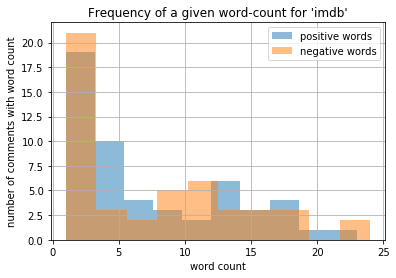

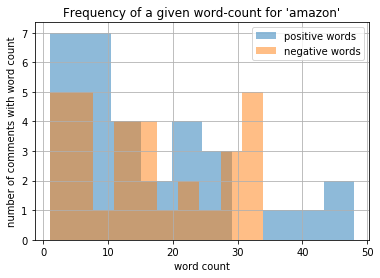

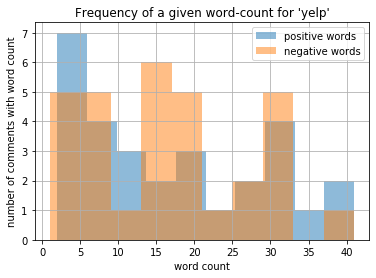

In [495]:
for website in datasets.keys():
    plt.hist(datasets[website]['word_count'].loc[datasets[website]
                                                 ['positive'] == True].value_counts(sort=False), label='positive words', alpha = 0.5)
    plt.hist(datasets[website]['word_count'].loc[datasets[website]['positive']
                                                 == False].value_counts(sort=False), label='negative words', alpha = 0.5)
    
    plt.title("Frequency of a given word-count for '{}'".format(website))
    plt.xlabel('word count')
    plt.ylabel('number of comments with word count')
    plt.legend()
    plt.grid()
    plt.show()

In [499]:
amazon.groupby(by = 'positive').mean()

,word_count
positive,
False,11.26
True,10.60


We notice that positive comments tend to be somewhat shorter than negative comments. 

In [500]:
amazon['word_count'].loc[amazon['positive'] == True].value_counts(sort = False, bins = 3)

(0.968, 11.333]     320
(11.333, 21.667]    126
(21.667, 32.0]       54
Name: word_count, dtype: int64

In [501]:
amazon['sent_length'] = pd.cut(amazon['word_count'], bins=3, labels=[
                               'short', 'mean_length', 'long'])

amazon = pd.concat([amazon, pd.get_dummies(amazon['sent_length'])], axis=1)
amazon.drop(columns = ['sent_length'], inplace = True)
amazon

,comment,positive,word_count,short,mean_length,long
0,so there is no way for me to plug it in here i...,False,21,0,1,0
1,"good case, excellent value",True,5,1,0,0
2,great for the jawbone,True,4,1,0,0
3,tied to charger for conversations lasting more...,False,13,0,1,0
4,the mic is great,True,4,1,0,0
...,...,...,...,...,...,...
995,the screen does get smudged easily because it ...,False,13,0,1,0
996,what a piece of junk i lose more calls on th...,False,12,0,1,0
997,item does not match picture,False,5,1,0,0
998,the only thing that disappoint me is the infra...,False,14,0,1,0


## Creating model v1

Let's start by focussing on the Amazon model.

In [502]:
cols = list(amazon.columns)
cols.remove('comment')
cols.remove('positive')

data_amazon = amazon[cols]
target_amazon = amazon['positive']

data_amazon

,word_count,short,mean_length,long
0,21,0,1,0
1,5,1,0,0
2,4,1,0,0
3,13,0,1,0
4,4,1,0,0
...,...,...,...,...
995,13,0,1,0
996,12,0,1,0
997,5,1,0,0
998,14,0,1,0


In [503]:
from sklearn.naive_bayes import BernoulliNB

bnb_amazon = BernoulliNB()
bnb_amazon.fit(data_amazon, target_amazon)
y_pred_amazon = bnb_amazon.predict(data_amazon)

print("Number of mislabeled points out of a total {} points : {} or {}%".format(
    data_amazon.shape[0], (target_amazon != y_pred_amazon).sum(
    ), (target_amazon != y_pred_amazon).sum()/len(y_pred_amazon)
))

Number of mislabeled points out of a total 1000 points : 465 or 0.465%


Not a bad start, but surely we can do better. We now do a 75/25 split on the data to get our training and test data.

In [504]:
from sklearn.model_selection import train_test_split

def create_fit_model(website, keywords = None, return_model = False):
    
    data = website.copy()
    
    #Feature engineering
    if keywords is not None:
        keywords = np.unique(keywords)
        for key in keywords:
            data[str(key)] = data['comment'].str.contains(str(key) + ' ', case = False) 
            
    #Creating comments
    cols = list(data.columns)
    cols.remove('comment')
    cols.remove('positive')

    X = data[cols]
    Y = data['positive']
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state = 13, shuffle = True)
    
    #Creating model
    model = BernoulliNB()
    model.fit(X_train, Y_train)
    
    pred = model.predict(X_test)
    accuracy = sum(pred == Y_test)/len(Y_test)
    
    if return_model:
        print('Model with {} accuracy is returned.'.format(accuracy))
        return model
    else:
        return accuracy

And the original model is...

In [505]:
create_fit_model(amazon)

0.512

Which is comparable to the a ~50% accuracy. 

## Adding new features to the dataset 

We start out by getting the word counts of the most popular words for positive and negative sentences.

Since some of these comments are likely to have improper punctuation, we replace all '.'s and '--'s with spaces.

In [506]:
amazon.head(15)

,comment,positive,word_count,short,mean_length,long
0,so there is no way for me to plug it in here i...,False,21,0,1,0
1,"good case, excellent value",True,5,1,0,0
2,great for the jawbone,True,4,1,0,0
3,tied to charger for conversations lasting more...,False,13,0,1,0
4,the mic is great,True,4,1,0,0
5,i have to jiggle the plug to get it to line up...,False,17,0,1,0
6,if you have several dozen or several hundred c...,False,22,0,0,1
7,if you are razr owner you must have this!,True,10,1,0,0
8,"needless to say, i wasted my money",False,8,1,0,0
9,what a waste of money and time!,False,8,1,0,0


In [507]:
from collections import Counter
from nltk.tokenize import word_tokenize
import operator

all_positive = ' '.join(amazon['comment'].loc[amazon['positive'] == True])
positive_words = word_tokenize(all_positive)
positive_words = [w for w in positive_words if len(w) > 2]

positive_word_count = dict()
counts = Counter(positive_words)

for word in np.unique(positive_words):
    positive_word_count[word] = sum(counts[i] for i in [word])

positive_words_df = pd.DataFrame.from_dict(positive_word_count, orient='index', columns=['pos_count'])
positive_words_df.index.rename('word', inplace = True)
positive_words_df.reset_index(inplace = True)
positive_words_df.sort_values(by = 'pos_count', ascending = False, inplace = True)
positive_words_df[:15]

,word,pos_count
902,the,239
38,and,189
914,this,105
396,great,94
653,phone,88
976,very,69
357,for,66
391,good,65
1021,with,65
1030,works,46


And similarly do the same for negative words.

In [508]:
all_negative = ' '.join(amazon['comment'].loc[amazon['positive'] != True])
negative_words = word_tokenize(all_negative)
negative_words = [w for w in negative_words if len(w) > 2]

negative_word_count = dict()
counts = Counter(negative_words)

for word in np.unique(negative_words):
    negative_word_count[word] = sum(counts[i] for i in [word])

negative_words_df = pd.DataFrame.from_dict(negative_word_count, orient='index', columns=['neg_count'])
negative_words_df.index.rename('word', inplace = True)
negative_words_df.reset_index(inplace = True)
negative_words_df.sort_values(by = 'neg_count', ascending = False, inplace = True)
negative_words_df[:15]

,word,neg_count
1022,the,280
698,not,143
40,and,122
1036,this,103
751,phone,80
408,for,55
1127,was,54
1020,that,49
1189,you,47
1166,with,47


We now outer merge these dfs to understand what are the unique words.

In [509]:
all_words = positive_words_df.merge(negative_words_df, on='word', how='outer')
all_words.fillna(0, inplace=True)
all_words['sentiment_score'] = (all_words['pos_count'] - all_words['neg_count'])

all_words.sort_values(by='sentiment_score', inplace=True)

We build our keyword set using the top 'n' values of the words with the highest and lowest keywords.

In [510]:
all_words

,word,pos_count,neg_count,sentiment_score
22,not,23.0,143.0,-120.0
0,the,239.0,280.0,-41.0
69,does,9.0,33.0,-24.0
21,you,24.0,47.0,-23.0
11,was,36.0,54.0,-18.0
...,...,...,...,...
5,very,69.0,35.0,34.0
9,works,46.0,1.0,45.0
7,good,65.0,13.0,52.0
1,and,189.0,122.0,67.0


In [511]:
all_words['word'].loc[(all_words['word'].str.isalpha(
) == False) & (abs(all_words['sentiment_score']) > 0)].values

array(["'ll", 's***', "'re", "'ve"], dtype=object)

In [512]:
def keyword_builder(n_pos, n_neg):
    
    positive_key_words, negative_key_words = [], []
    
    if n_pos > 0:
        positive_key_words = list(all_words['word'][-n_pos:].values)
        
    if n_neg > 0:
        negative_key_words = list(all_words['word'][:n_neg].values)
    
    keywords = positive_key_words + negative_key_words
    
    return keywords

In [513]:
keywords_amazon = keyword_builder(9, 9)

create_fit_model(amazon, keywords_amazon)

0.68

In [514]:
accuracy_dict_all = dict()

for i in range(1, 120):
    accuracy_dict_all[i] = create_fit_model(amazon, keyword_builder(i, i))
    
    if i % 10 == 0:
        print('Accuracy: {} (n_pos = {}, n_neg = {})'.format(accuracy_dict_all[i], i, i))

Accuracy: 0.696 (n_pos = 10, n_neg = 10)
Accuracy: 0.76 (n_pos = 20, n_neg = 20)
Accuracy: 0.764 (n_pos = 30, n_neg = 30)
Accuracy: 0.792 (n_pos = 40, n_neg = 40)
Accuracy: 0.816 (n_pos = 50, n_neg = 50)
Accuracy: 0.84 (n_pos = 60, n_neg = 60)
Accuracy: 0.832 (n_pos = 70, n_neg = 70)
Accuracy: 0.828 (n_pos = 80, n_neg = 80)
Accuracy: 0.824 (n_pos = 90, n_neg = 90)
Accuracy: 0.84 (n_pos = 100, n_neg = 100)
Accuracy: 0.844 (n_pos = 110, n_neg = 110)


In [515]:
accuracy_dict_only_pos = dict()

for i in range(1, 120):
    accuracy_dict_only_pos[i] = create_fit_model(amazon, keyword_builder(i, 0))
    
    if i % 10 == 0:
        print('Accuracy: {} (n_pos = {}, n_neg = {})'.format(accuracy_dict_only_pos[i], i, 0))

Accuracy: 0.68 (n_pos = 10, n_neg = 0)
Accuracy: 0.744 (n_pos = 20, n_neg = 0)
Accuracy: 0.712 (n_pos = 30, n_neg = 0)
Accuracy: 0.744 (n_pos = 40, n_neg = 0)
Accuracy: 0.752 (n_pos = 50, n_neg = 0)
Accuracy: 0.76 (n_pos = 60, n_neg = 0)
Accuracy: 0.756 (n_pos = 70, n_neg = 0)
Accuracy: 0.752 (n_pos = 80, n_neg = 0)
Accuracy: 0.76 (n_pos = 90, n_neg = 0)
Accuracy: 0.76 (n_pos = 100, n_neg = 0)
Accuracy: 0.76 (n_pos = 110, n_neg = 0)


In [516]:
accuracy_dict_only_neg = dict()

for i in range(1, 120):
    accuracy_dict_only_neg[i] = create_fit_model(amazon, keyword_builder(0, i))
    
    if i % 10 == 0:
        print('Accuracy: {} (n_pos = {}, n_neg = {})'.format(accuracy_dict_only_neg[i], 0, i))

Accuracy: 0.624 (n_pos = 0, n_neg = 10)
Accuracy: 0.704 (n_pos = 0, n_neg = 20)
Accuracy: 0.744 (n_pos = 0, n_neg = 30)
Accuracy: 0.756 (n_pos = 0, n_neg = 40)
Accuracy: 0.74 (n_pos = 0, n_neg = 50)
Accuracy: 0.744 (n_pos = 0, n_neg = 60)
Accuracy: 0.752 (n_pos = 0, n_neg = 70)
Accuracy: 0.756 (n_pos = 0, n_neg = 80)
Accuracy: 0.744 (n_pos = 0, n_neg = 90)
Accuracy: 0.756 (n_pos = 0, n_neg = 100)
Accuracy: 0.756 (n_pos = 0, n_neg = 110)


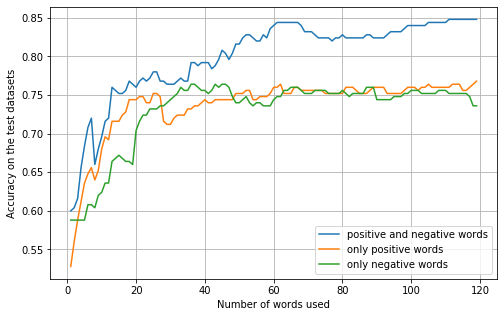

In [517]:
plt.figure(figsize= (8, 5))

x, y = zip(*accuracy_dict_all.items())
plt.plot(x, y, label = 'positive and negative words')

x_pos, y_pos = zip(*accuracy_dict_only_pos.items())
plt.plot(x_pos, y_pos, label = 'only positive words')

x_neg, y_neg = zip(*accuracy_dict_only_neg.items())
plt.plot(x_neg, y_neg, label = 'only negative words')

plt.legend()
plt.grid()
plt.ylabel('Accuracy on the test datasets')
plt.xlabel('Number of words used')
plt.show()

We notice that the 80% accuracy threshold is broken around the ~45 positive and 45 negative word mark, and as such, we will use that as our best model.

In [518]:
model_v2 = create_fit_model(amazon, keyword_builder(45, 45), return_model=True)

Model with 0.808 accuracy is returned.


We now experiment with `n_pos` and `n_neg` values around i = 45 to further fine-tune the model. Our goal is to find the least number of words that provide at least 80% sentiment prediction.

In [520]:
accuracy_to_beat = 0.8

sum_to_beat = 45 + 45
lowest_so_far = sum_to_beat

accuracy_dict_fine_tune = dict()

for i in range(25, 55):
    for j in range(25, 55):
        if i + j >= sum_to_beat:
            continue
        
        accuracy = create_fit_model(amazon, keyword_builder(i, j)) 
        word_sum = i + j
        
        if accuracy > accuracy_to_beat:    
            accuracy_dict_fine_tune[i, j] = accuracy
            
            if (word_sum < lowest_so_far):
                lowest_so_far = word_sum
                print('Accuracy: {} (n_pos = {}, n_neg = {}, word_sum = {}) **'.format(accuracy, i, j, word_sum))
            elif (abs(word_sum - lowest_so_far) <= 5):
                print('Accuracy: {} (n_pos = {}, n_neg = {}, word_sum = {})'.format(accuracy, i, j, word_sum))

Accuracy: 0.808 (n_pos = 25, n_neg = 36, word_sum = 61) **
Accuracy: 0.808 (n_pos = 25, n_neg = 37, word_sum = 62)
Accuracy: 0.804 (n_pos = 25, n_neg = 38, word_sum = 63)
Accuracy: 0.808 (n_pos = 26, n_neg = 36, word_sum = 62)
Accuracy: 0.808 (n_pos = 26, n_neg = 37, word_sum = 63)
Accuracy: 0.804 (n_pos = 26, n_neg = 38, word_sum = 64)
Accuracy: 0.804 (n_pos = 26, n_neg = 39, word_sum = 65)


We notice that `n_pos` = 25 and `n_neg` = 36 are provide the lowest possible number of keywords that predict the sentiment with at least 80% prediction accuracy. These are the following words:

In [521]:
pos_features = all_words[-25:][['word', 'sentiment_score']].sort_values(by = 'sentiment_score', ascending = False)
pos_features[:10]

,word,sentiment_score
3,great,89.0
1,and,67.0
7,good,52.0
9,works,45.0
5,very,34.0
12,well,28.0
18,excellent,25.0
19,price,23.0
25,nice,22.0
32,love,20.0


In [522]:
neg_features = all_words[:36][['word', 'sentiment_score']].sort_values(by = 'sentiment_score', ascending = True)
neg_features[:10]

,word,sentiment_score
22,not,-120.0
0,the,-41.0
69,does,-24.0
21,you,-23.0
11,was,-18.0
1017,money,-17.0
14,that,-16.0
70,work,-16.0
1044,poor,-15.0
397,first,-15.0


In [523]:
features = list(pos_features['word'].unique()) + list(neg_features['word'].unique())
len(features)

61

## Saving the amazon model

In [524]:
keywords_amazon = keyword_builder(n_pos=25, n_neg=36)

final_model_amazon = create_fit_model(
    amazon, keywords_amazon, return_model=True)

Model with 0.808 accuracy is returned.


## Testing the Amazon model on the Yelp and IMDb datasets

In [525]:
yelp.head()

,comment,positive,word_count
0,wow loved this place,True,4
1,crust is not good,False,4
2,not tasty and the texture was just nasty,False,8
3,stopped by during the late may bank holiday of...,True,15
4,the selection on the menu was great and so wer...,True,12


In [526]:
yelp['sent_length'] = pd.cut(yelp['word_count'], bins=3, labels=[
                               'short', 'mean_length', 'long'])

yelp = pd.concat([yelp, pd.get_dummies(yelp['sent_length'])], axis=1)
yelp.drop(columns = ['sent_length'], inplace = True)

yelp = yelp.reindex(list(yelp) + features, axis= 1)

for f in features:
    yelp[f] = yelp['comment'].str.count(f)

yelp[['comment', 'good', 'great', 'not', 'the']]

,comment,good,great,not,the
0,wow loved this place,0,0,0,0
1,crust is not good,1,0,1,0
2,not tasty and the texture was just nasty,0,0,1,1
3,stopped by during the late may bank holiday of...,0,0,0,1
4,the selection on the menu was great and so wer...,0,1,0,3
...,...,...,...,...,...
995,i think food should have flavor and texture an...,0,0,0,0
996,appetite instantly gone,0,0,0,0
997,overall i was not impressed and would not go b...,0,0,2,0
998,"the whole experience was underwhelming, and i ...",0,0,0,1


In [527]:
imdb['sent_length'] = pd.cut(imdb['word_count'], bins=3, labels=[
                               'short', 'mean_length', 'long'])

imdb = pd.concat([imdb, pd.get_dummies(imdb['sent_length'])], axis=1)
imdb.drop(columns = ['sent_length'], inplace = True)

for f in features:
    imdb[f] = imdb['comment'].str.count(f)
    
imdb[['comment', 'good', 'great', 'not', 'the']]

,comment,good,great,not,the
0,"a very, very, very slow moving, aimless movie ...",0,0,0,0
1,not sure who was more lost the flat characte...,0,0,1,2
2,attempting artiness with black & white and cle...,0,0,0,3
3,very little music or anything to speak of,0,0,0,0
4,the best scene in the movie was when gerardo i...,0,0,0,2
...,...,...,...,...,...
743,i just got bored watching jessice lange take h...,0,0,0,1
744,"unfortunately, any virtue in this film's produ...",0,0,0,0
745,"in a word, it is embarrassing",0,0,0,0
746,exceptionally bad!,0,0,0,0


In [528]:
cols = list(yelp.columns)
cols.remove('comment')
cols.remove('positive')

X_yelp = yelp[cols]
Y_yelp = yelp['positive']

pred = final_model_amazon.predict(X_yelp)
accuracy = sum(pred == Y_yelp)/len(Y_yelp)
accuracy

0.51

In [529]:
cols = list(imdb.columns)
cols.remove('comment')
cols.remove('positive')

X_imdb = imdb[cols]
Y_imdb = imdb['positive']

pred = final_model_amazon.predict(X_imdb)
accuracy = sum(pred == Y_imdb)/len(Y_imdb)
accuracy

0.4732620320855615

As expected, the amazon comments sentiment classifier is highly irrelevant to the IMDb and Yelp datasets, and the prediction accuracy is no greater than the flip of a coin. 